<a href="https://www.kaggle.com/code/nikhilchadha1537/bank-churn-playground-problem?scriptVersionId=159201184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean, std
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import optuna

# **Data Analysis**

In [164]:
train_data_file = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv",index_col="id")
test_data_file = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv",index_col="id")

In [165]:
train_data_file.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [166]:
train_data_file.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [167]:
train_data_file.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [168]:
train_data_file.shape, test_data_file.shape

((165034, 13), (110023, 12))

In [169]:
train_data_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [170]:
train_data_file.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

In [171]:
train_data_file.drop_duplicates(inplace=True , keep="first")

In [172]:
train_data_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [173]:
train_data_file.Geography.value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

In [174]:
train_data_file.NumOfProducts.value_counts()

NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

In [175]:
train_data_file.IsActiveMember.describe()

count    165034.000000
mean          0.497770
std           0.499997
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: IsActiveMember, dtype: float64

# 3 Object data types have been found

**These need to be Encoded**

# Label Encoding

In [176]:
from sklearn.preprocessing import LabelEncoder
labelencode = LabelEncoder()
def encode(train_data_file):
    for col in train_data_file.columns:
        if train_data_file[col].dtypes=='object':
            train_data_file[col]=labelencode.fit_transform(train_data_file[col])
    return train_data_file

train_data_file=encode(train_data_file)
test_data_file=encode(test_data_file)

In [177]:
train_data_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  int64  
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  int64  
 4   Gender           165034 non-null  int64  
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 17.6 MB


In [178]:
train_data_file.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,1924,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,1925,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,1178,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,1299,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,467,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


# Checking

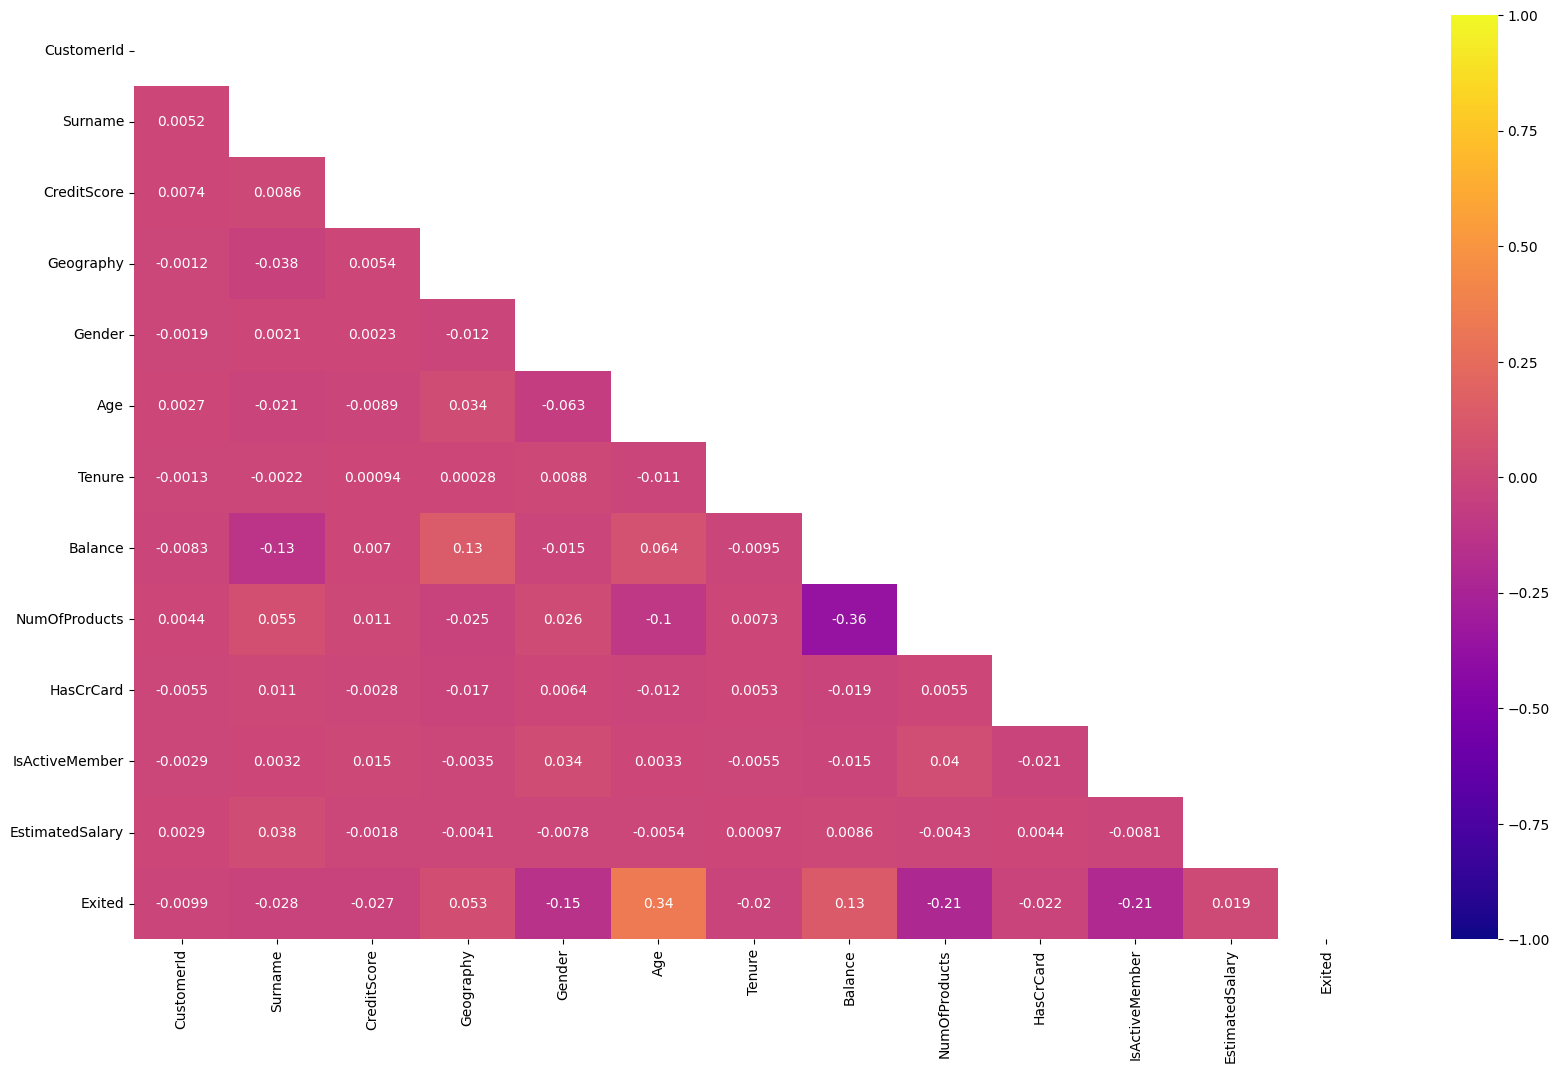

In [179]:
mask = np.triu(np.ones_like(train_data_file.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(train_data_file.corr(), cmap="plasma", annot=True, mask=mask,vmin=-1,vmax=1);

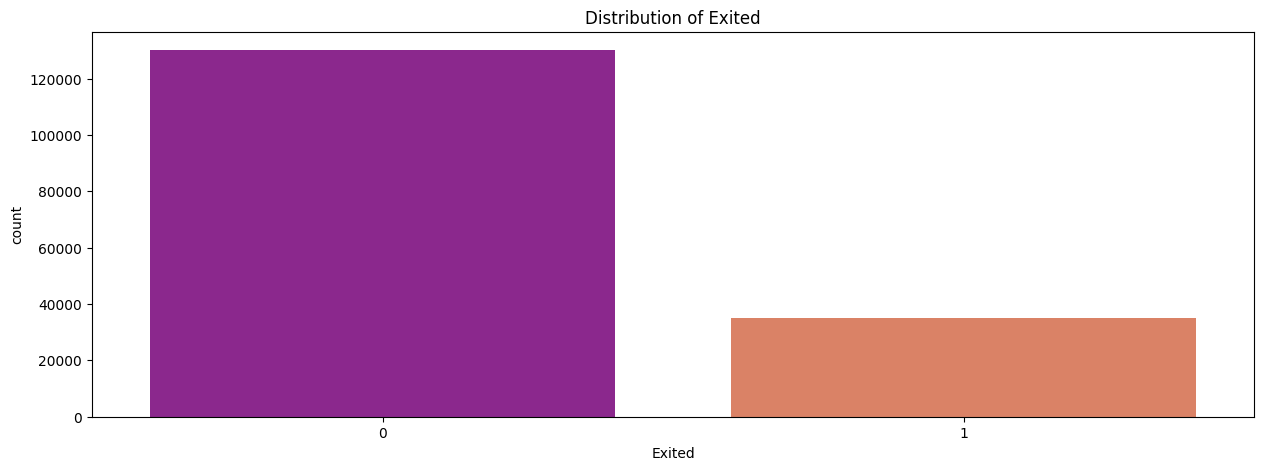

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(data=train_data_file,x="Exited", palette = "plasma");
plt.title("Distribution of Exited")

fig.show();

**It is Biased towards 0**

# Modelling

In [181]:
X = train_data_file.drop("Exited",axis=1)
y = train_data_file.Exited

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3)
print(len(X_train),len(X_val))

115523 49511


In [182]:
from sklearn.tree import DecisionTreeClassifier
model1 = DecisionTreeClassifier()
model1.fit(X_train,y_train)
print("ROC AUC of DT:",roc_auc_score(model1.predict(X_val),y_val))

ROC AUC of DT: 0.696139931986985


In [183]:
MODEL2= XGBClassifier()
MODEL2.fit(X_train,y_train)
print("ROC AUC of XGB:",roc_auc_score(MODEL2.predict(X_val),y_val))

ROC AUC of XGB: 0.8132183870177361


In [184]:
model3=RandomForestClassifier()
model3.fit(X_train,y_train)
print("ROC AUC of RF:",roc_auc_score(model3.predict(X_val),y_val))

ROC AUC of RF: 0.8118449209332297


In [185]:
MODEL4 = LGBMClassifier(verbose=-1)
MODEL4.fit(X_train,y_train)
print("ROC AUC of LGBM:",roc_auc_score(MODEL4.predict(X_val),y_val))

ROC AUC of LGBM: 0.8182938860670955


# Creating Output for Submission

In [186]:
submission = pd.DataFrame()
submission["id"] = test_data_file.index
submission["Exited"] = (model3.predict_proba(test_data_file)[:,1]+MODEL4.predict_proba(test_data_file)[:,1])/2

submission.to_csv("submission.csv",header=True,index=False)
submission

,id,Exited
0,165034,0.048253
1,165035,0.862769
2,165036,0.023314
3,165037,0.334941
4,165038,0.336779
...,...,...
110018,275052,0.049256
110019,275053,0.088130
110020,275054,0.014204
110021,275055,0.217686
